# XGBoostClassifier

_Currently, this notebook does not work on macOS. This issue is being investigated._

In [13]:
import warnings

import matplotlib.pyplot as plt
import numpy
from sklearn.datasets import fetch_openml, make_circles
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier

from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

%matplotlib inline

### Let's define some data to classify

In [2]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.6, random_state=0)

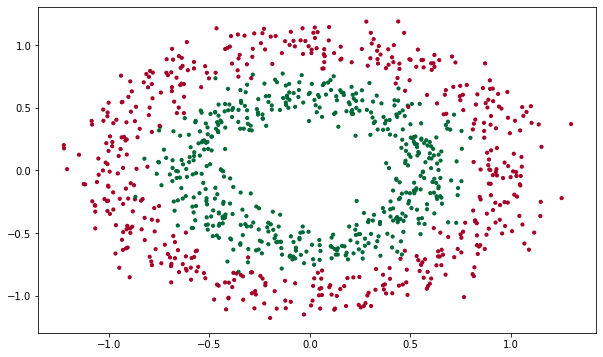

In [3]:
# Define the figure size
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="RdYlGn")
plt.show()

In [4]:
n_estimators = 50
max_depth = 4
n_bits = 7

### This is how to classify with scikit-learn

In [ ]:
sklearn_clf = SklearnXGBClassifier(n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth)
sklearn_clf.fit(X, y)

### And this is how to classify with Concrete ML: pretty much the same

In [5]:
concrete_clf = ConcreteXGBClassifier(n_bits=n_bits, n_estimators=n_estimators, max_depth=max_depth)
concrete_clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1)

### Now, let's see the classifications

In [7]:
def plot_contour(clf, X, y):
    # Create a grid will lots of point to plot the countour of the decision function
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    grid_x, grid_y = numpy.meshgrid(
        numpy.arange(x_min, x_max, 0.1), numpy.arange(y_min, y_max, 0.1)
    )
    # Predict the function value on the grid
    grid_z = clf.predict_proba(numpy.c_[grid_x.ravel(), grid_y.ravel()])[:, 1]
    # grid_z = clf.predict(numpy.c_[grid_x.ravel(), grid_y.ravel()])
    grid_z = grid_z.reshape(grid_x.shape)
    # Define the plot size
    plt.figure(figsize=(10, 6))
    # Plot the contour and training examples
    plt.contourf(grid_x, grid_y, grid_z, cmap="RdYlGn", alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="RdYlGn")
    plt.show()

With scikit-learn

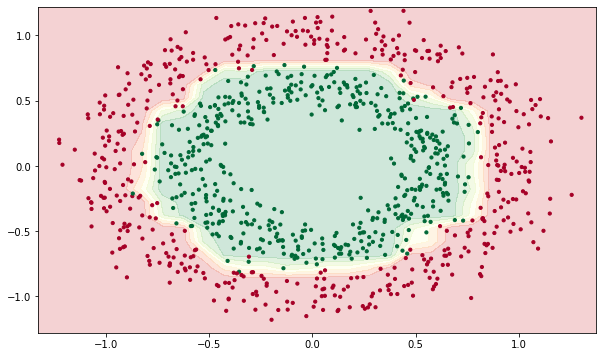

In [9]:
plot_contour(sklearn_clf, X, y)

And with Concrete ML

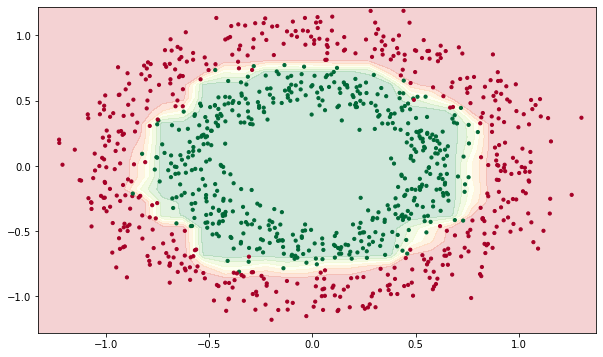

In [8]:
plot_contour(concrete_clf, X, y)

### And now, on the diabetes datasets

In [10]:
X, y = fetch_openml(name="diabetes", as_frame=False, cache=True, return_X_y=True)
y[y == "tested_positive"] = 1
y[y == "tested_negative"] = 0
y = y.astype(numpy.int)

In [11]:
# Create scorer with the MCC metric
grid_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

In [12]:
param_grid = {
    "n_bits": [7],
    "max_depth": [2],
    "n_estimators": [1, 5, 10, 50, 100],
}
concrete_clf = ConcreteXGBClassifier()
gs_concrete = GridSearchCV(
    concrete_clf, param_grid, cv=5, scoring=grid_scorer, verbose=1, n_jobs=-1
).fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [13]:
warnings.filterwarnings("ignore")
param_grid = {
    "max_depth": [2],
    "n_estimators": [1, 5, 10, 50, 100],
}
sklearn_clf = SklearnXGBClassifier()
gs_sklearn = GridSearchCV(
    sklearn_clf, param_grid, cv=5, scoring=grid_scorer, verbose=1, n_jobs=-1
).fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [14]:
# Print mean time fit and std time fit for both models
print(
    f"Mean time fit concrete: {numpy.mean(gs_concrete.cv_results_['mean_fit_time']):.2f}s,"
    f"std time fit concrete: {numpy.std(gs_concrete.cv_results_['mean_fit_time']):.2f}s"
)

print(
    f"Mean time fit sklearn: {numpy.mean(gs_sklearn.cv_results_['mean_fit_time']):.2f}s,"
    f" std time fit sklearn: {numpy.std(gs_sklearn.cv_results_['mean_fit_time']):.2f}s"
)

Mean time fit concrete: 54.16s,std time fit concrete: 49.16s
Mean time fit sklearn: 45.28s, std time fit sklearn: 43.25s


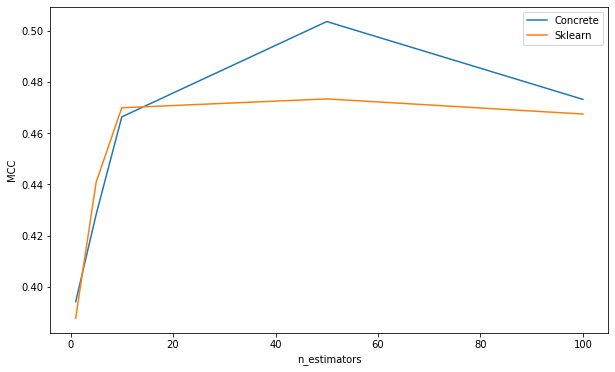

In [15]:
# Define the figure size
plt.figure(figsize=(10, 6))
# Plot the mean_test_score of both model along the n_estimators hyperparameter
plt.plot(
    gs_concrete.cv_results_["param_n_estimators"],
    gs_concrete.cv_results_["mean_test_score"],
    label="Concrete",
)
plt.plot(
    gs_sklearn.cv_results_["param_n_estimators"],
    gs_sklearn.cv_results_["mean_test_score"],
    label="Sklearn",
)
plt.xlabel("n_estimators")
plt.ylabel("MCC")
plt.legend()
plt.show()